In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# PRINT IMAGES

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [206]:
# LOAD, TRANSFORM AND STORE DATA

class Recognition(object):
    def __init__(self, data_path='orl_faces/', n_class=40, resize=None):
        self.data_path = data_path
        self.n_class = n_class
        self.data = self.load_faces()
        if resize is not None:
            self.resized_data = self.resize(resize)
        else:
            self.resized_data = self.data
        self.phi = self.build_phi()
        self.gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(self.phi), self.phi)))
        self.true_class = [j for l in [[i+1]*5 for i in range(40)] for j in l]

    def load_faces(self):
        data = dict()
        for i in range(1, 41):
            images = list()
            for j in range(1, 11):
                path = self.data_path + 's' + str(i) + '/' + str(j) + '.pgm'
                images.append(cv2.imread(path, 0))
            data[i] = images
        return data

    def show(self, i, j):
        plt.imshow(self.resized_data[i][j])
        plt.title('my picture')
        plt.show()

    def resize(self, dsize):
        resized_data = dict()
        for i, l in self.data.items():
            images = list()
            for img in l:
                images.append(cv2.resize(img, dsize, interpolation=cv2.INTER_AREA))
            resized_data[i] = images
        return resized_data

    def build_phi(self):
        images = list()
        for i, l in self.resized_data.items():
            images += l[:5]
        return np.transpose(np.vstack([img.flatten() for img in images]))

In [12]:
# SHRINK

def shrink_(x, y):
    if x > y:
        return x - y
    elif x < -y:
        return x + y
    else:
        return 0

shrink = np.vectorize(shrink_)

In [5]:
    def minimization_with_occlusion(self, y, epsilon=0.15, niter=20):
        m, n = self.phi.shape
        iter_ = 0
        # phi = np.random.randint(2, 200, (m, n))
        self.gamma = 10000000000

        shrink = np.vectorize(self.shrink)
        c = np.zeros(n)
        e = np.copy(y)
        v = np.zeros(m)
        mu = 2*25**2/np.linalg.norm(y, ord=1)
        print('mu: ', mu)
        de = np.ones(n)
        dc = np.ones(n)
        while np.linalg.norm(dc) > epsilon and iter_ < niter:
            iter_ += 1
            if iter_%100 == 0:
                show_images([(np.dot(self.phi, c)).astype('uint8').reshape((25, 25)), (e).astype('uint8').reshape((25, 25))])
            #print('de: ', np.linalg.norm(de))
            #print('dc: ', np.linalg.norm(dc))
            #print('dpc: ', np.linalg.norm(np.dot(self.phi, dc)))
            #print('------------------------')

            de = shrink(y - np.dot(self.phi, c) + v / mu, 1 / mu) - e
            e += de
            t = 1
            z = np.ones(n)
            w = np.copy(c)
            dw = np.ones(n)
            while np.linalg.norm(dw) > 0.005:
                # print('dw: ', np.linalg.norm(dw))
                left = z + np.dot(np.transpose(self.phi), y - np.dot(self.phi, z) - e + v / mu) / self.gamma
                dw = shrink(left, 1 / (mu * self.gamma)) - w
                w += dw
                dt = (1 + np.sqrt(1 + 4 * t ** 2)) / 2 - t
                t += dt
                z = w + (t - dt - 1) / t * dw

            dc = w - c
            c += dc
            v = v + mu *(y - np.dot(self.phi, c) - e)
            # mu += 0.1
        return c, e

    def minimization_post_c(self, y, c, epsilon=0.15):
        m, n = self.phi.shape

        # phi = np.random.randint(2, 200, (m, n))
        self.gamma = 10000000000

        shrink = np.vectorize(self.shrink)
        e = np.copy(y)
        v = np.zeros(m)
        mu = 2*25**2/np.linalg.norm(y, ord=1)
        de = np.ones(n)
        while np.linalg.norm(de) > epsilon:
            print('de: ', np.linalg.norm(de))
            #print('dc: ', np.linalg.norm(dc))

            de = shrink(y - np.dot(self.phi, c) + v / mu, 1 / mu) - e
            e += de
            t = 1
            v = v + mu *(y - np.dot(self.phi, c) - e)
            mu += 0.1
        return e
    
    def minimization(self, y, epsilon=0.15):
        iter_ = 0
        m, n = self.phi.shape
        # phi = np.random.randint(2, 200, (m, n))
        self.gamma = 10000000000

        shrink = np.vectorize(self.shrink)
        c = np.zeros(n)
        v = np.zeros(m)
        mu = 2*25**2/np.linalg.norm(y, ord=1)
        de = np.ones(n)
        dc = np.ones(n)
        while np.linalg.norm(dc) > epsilon and iter_ < 20:
            iter_ += 1
            # print('dc: ', np.linalg.norm(dc))
            t = 1
            z = np.ones(n)
            w = np.copy(c)
            dw = np.ones(n)
            while np.linalg.norm(dw) > 0.005:
                # print('dw: ', np.linalg.norm(dw))
                left = z + np.dot(np.transpose(self.phi), y - np.dot(self.phi, z) + v / mu) / self.gamma
                dw = shrink(left, 1 / (mu * self.gamma)) - w
                w += dw
                dt = (1 + np.sqrt(1 + 4 * t ** 2)) / 2 - t
                t += dt
                z = w + (t - dt - 1) / t * dw

            dc = w - c
            c += dc
            v = v + mu * (y - np.dot(self.phi, c))
            # mu += 1
        return c
    
    def knn(self, n_neighbors=3):
        l = [[i+1]*5 for i in range(40)]
        true_class =[j for l_ in l for j in l_]
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
        neigh.fit(np.transpose(self.phi), true_class)
        return neigh

# DATABASE

LA base de donnée **ORL Databases of faces** contient 400 photos de visages représentant 40 personnes (10 photos de resolution 112x92 pour chaque personne). On sépare la base en une base d'entraînement et une base de test contenant 5 images par individu chacune.

In [207]:
# load
reduction_size = (25, 25)
fr = Recognition(resize=reduction_size)

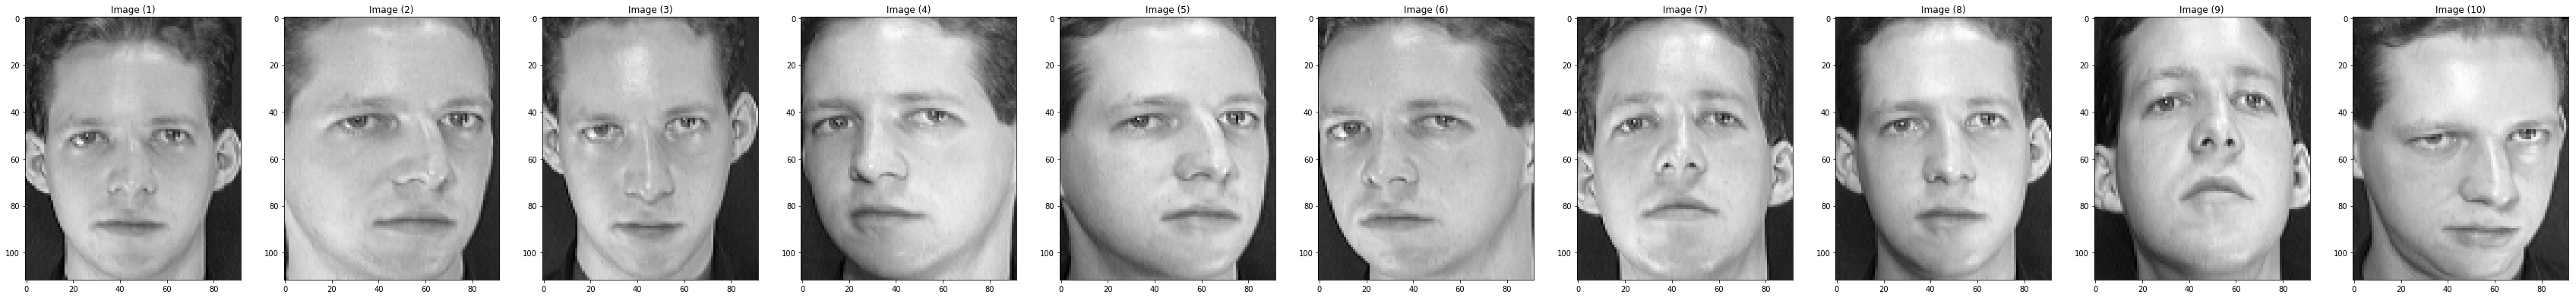

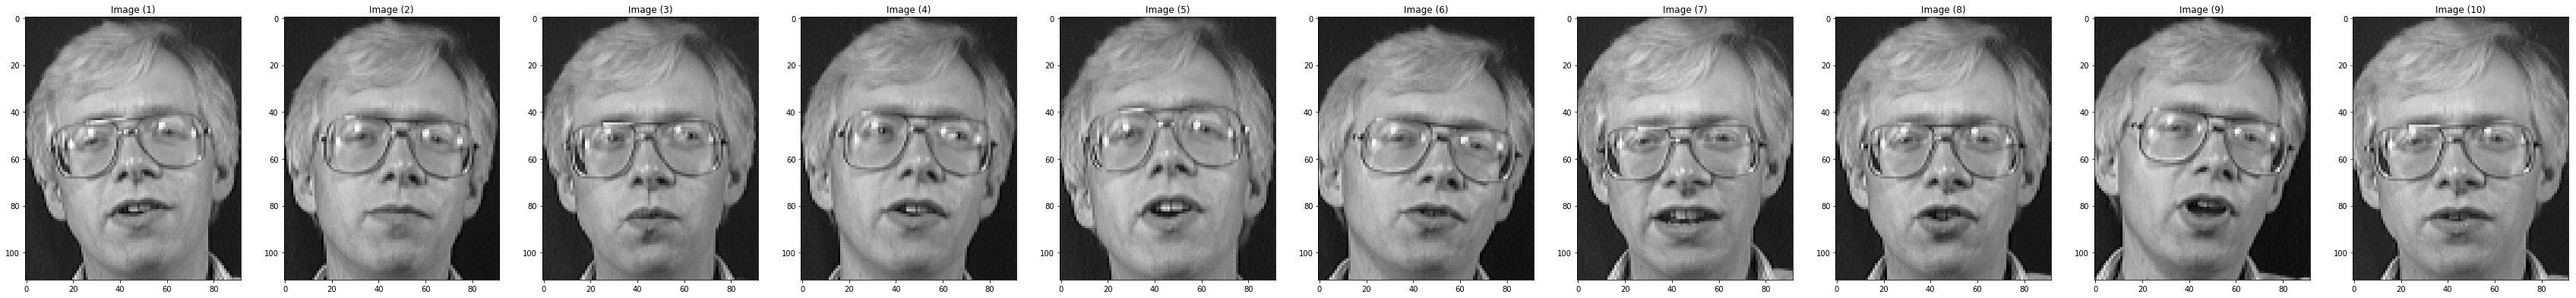

In [11]:
# show 2 persons
show_images(fr.data[1])
show_images(fr.data[2])

Il existe de nombreuses méthodes de réduction de dimension fournis dans le package de OpenCV. Nous choisirons par la suite **INTER_AREA** comme méthode par défaut.

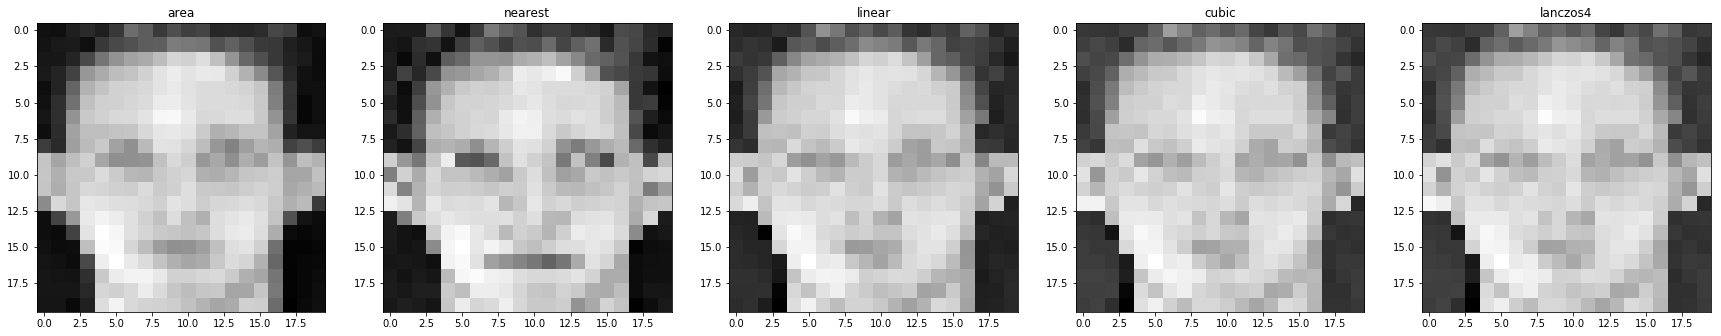

In [92]:
methods=[("area", cv2.INTER_AREA), 
         ("nearest", cv2.INTER_NEAREST), 
         ("linear", cv2.INTER_LINEAR), 
         ("cubic", cv2.INTER_CUBIC), 
         ("lanczos4", cv2.INTER_LANCZOS4)]

img = fr.data[1][0]
images, titles = [], []
for method in methods:
    images.append(cv2.resize(img, reduction_size, interpolation=method[1]))
    titles.append(method[0])
    
show_images(images, cols=1, titles=titles)

# Fast L1 minimisation

On cherche à minimiser la fonction de Lagrange augmentée:
$$
L_\mu(c, \nu) = \|c\|_1 + ⟨\nu,y-\Phi c⟩ + \frac{\mu}{2}\|y-\Phi c\|_2^2
$$

Pour cela on va approcher les grandeurs cibles par un algorithme iteratif. $$(c^*,\nu^*)$$

A chaque étape, on calcule:
$$
c_{k+1} = argmin_c L_{\mu_k}(c_k, \nu_k)
$$

$$
\nu_{k+1} = \nu_k + \mu_k(y-\Phi c_{k+1})
$$

L'optimisation de c se fait à l'aide d'un algorithme FISTA.

In [181]:
# ALGORITHM

def fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=1000):
    iter_ = 0
    m, n = fr.phi.shape
    c = np.zeros(n)
    v = np.zeros(m)
    de = np.ones(n)
    dc = np.ones(n)
    dc_list = []
    
    while np.linalg.norm(dc) > epsilon and iter_ < iter_max:
        iter_ += 1
        # print('dc: ', np.linalg.norm(dc))
        t = 1
        z = np.ones(n)
        w = np.copy(c)
        dw = np.ones(n)

        # FISTA
        while np.linalg.norm(dw) > epsilon_fista:
            # print('dw: ', np.linalg.norm(dw))
            left = z + np.dot(np.transpose(fr.phi), y - np.dot(fr.phi, z) + v / mu) / gamma
            dw = shrink(left, 1 / (mu * gamma)) - w
            w += dw
            dt = (1 + np.sqrt(1 + 4 * t ** 2)) / 2 - t
            t += dt
            z = w + (t - dt - 1) / t * dw

        dc = w - c
        dc_list.append(np.linalg.norm(dc))
        c += dc
        v = v + mu * (y - np.dot(fr.phi, c))
        mu += mu_iter
    return c, dc_list

In [71]:
print('eigenvalue max: ', np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi))))

eigenvalue max:  25430.706834753164


Dans la littérature, le paramètre gamma de l'algorithme FISTA doit etre égale à: $$ \gamma = \lambda_{max}\{\Phi^T\Phi\}$$
Après plusieurs tests, il s'avère que la suite diverge de façon exponentielle avec une tell valeur. Nous choisirons donc d'augmenter arbitrairement ce paramètre pour assurer la convergence de la suite. 

In [136]:
# PARAMETERS

epsilon = 0.1
epsilon_fista = 0.001

# gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi)))
gamma = 10000000000

mu = 2*reduction_size[0]*reduction_size[1]/np.linalg.norm(y, ord=1)

## Monitor the convergence depending on mu constant or increasing

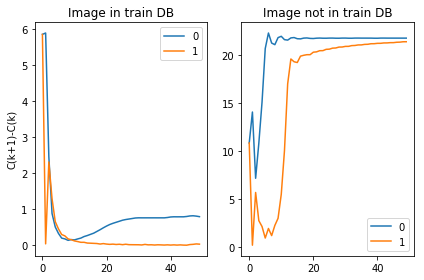

In [180]:
# load images
fr = Recognition(resize=reduction_size)

iter_max = 50
mu_iter_list = [0, 1]

# image in train DB
y1 = fr.resized_data[11][0].flatten().astype('float64')
# image not in train DB
y2 = fr.resized_data[11][6].flatten().astype('float64')

deltac = [[], []]
for dc, y in zip(deltac, [y1, y2]):
    for mu_i in mu_iter_list:
        # print(mu_i)
        c, dc_list = fast_l1_minimisation(fr, y, 0., epsilon_fista, gamma, mu, mu_i, iter_max=iter_max)
        dc.append(dc_list)
        
t = np.arange(iter_max)

plt.subplot(1, 2, 1)
plt.plot(t, deltac[0][0], t, deltac[0][1])
plt.legend(list(map(str, mu_iter_list)))
plt.title('Image in train DB')
plt.ylabel('C(k+1)-C(k)')

plt.subplot(1, 2, 2)
plt.plot(t, deltac[1][0], t, deltac[1][1])
plt.legend(list(map(str, mu_iter_list)))
plt.title('Image not in train DB')

plt.tight_layout()
plt.show()

=>

iter_max := 10

mu_iter := 1

## Find c with the fast l1 minimisation

### First on a face in the train DB

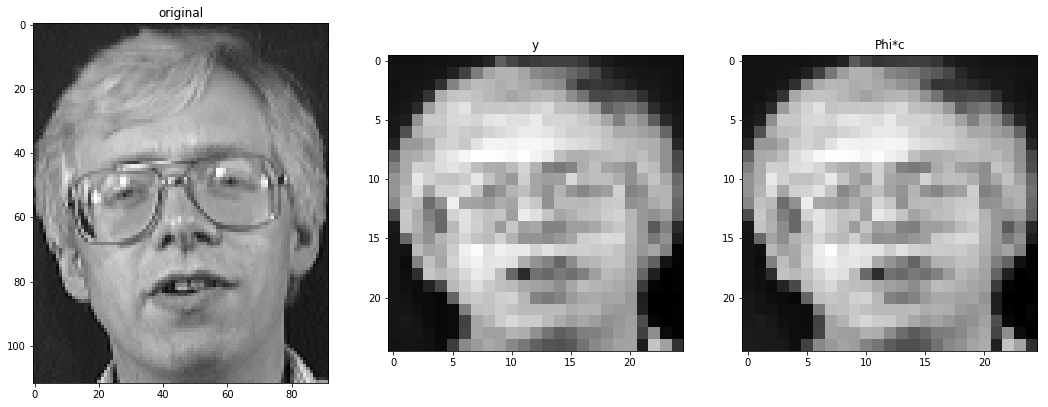

true class:  2
class:  2


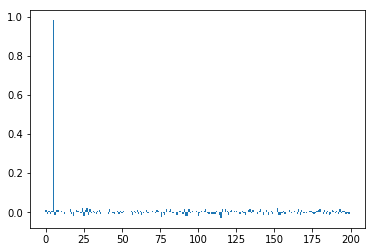

In [184]:
# load images
fr = Recognition(resize=reduction_size)

# choose the image to classify
n_person, n_img = (2, 0)
y = fr.resized_data[n_person][n_img].flatten().astype('float64')

c, c_list = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=10)

img = (np.dot(fr.phi, c)).astype('uint8').reshape(reduction_size)

images_to_show = [fr.data[n_person][n_img], fr.resized_data[n_person][n_img], img]
show_images(images_to_show, cols=1, titles=['original', 'y', 'Phi*c'])

print('true class: ', n_person)
print('class: ', np.argmax(c)//5+1)
plt.bar(np.arange(c.shape[0]), c)
plt.show()

### Then on a face in the test DB

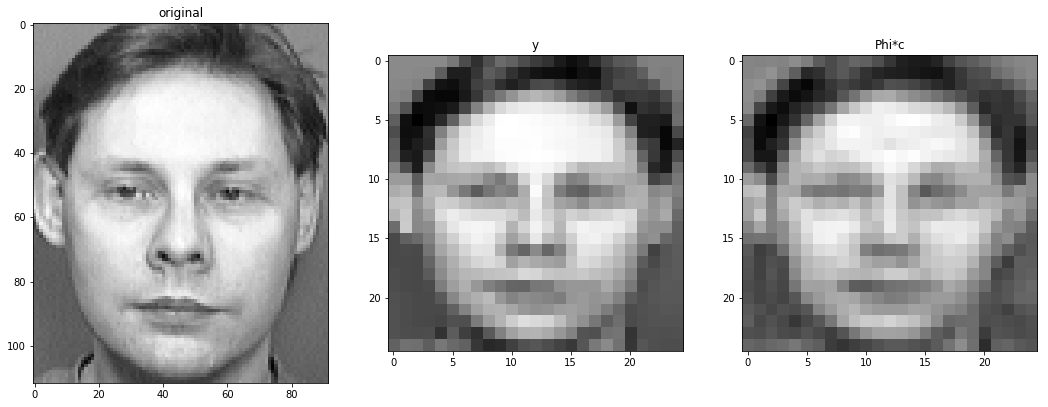

true class:  4
class:  4


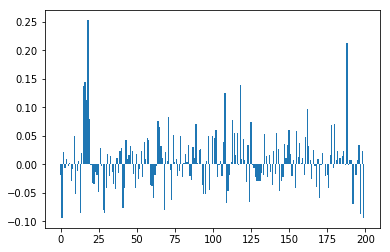

In [198]:
# load images
fr = Recognition(resize=reduction_size)

# choose the image to classify
n_person, n_img = (4, 6)
y = fr.resized_data[n_person][n_img].flatten().astype('float64')

c, c_list = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=10)

img = (np.dot(fr.phi, c)).astype('uint8').reshape(reduction_size)

images_to_show = [fr.data[n_person][n_img], fr.resized_data[n_person][n_img], img]
show_images(images_to_show, cols=1, titles=['original', 'y', 'Phi*c'])

print('true class: ', n_person)
print('class: ', np.argmax(c)//5+1)
plt.bar(np.arange(c.shape[0]), c)
plt.show()

# Compute the score

In [193]:
# PARAMETERS

epsilon = 0.1
epsilon_fista = 0.001

# gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi)))
gamma = 10000000000

mu = 2*reduction_size[0]*reduction_size[1]/np.linalg.norm(y, ord=1)
mu_iter = 1

iter_max = 10

In [223]:
c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = img.flatten().astype('float64')
        c_, dc = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        # print('class: ', np.argmax(c_)//5 + 1, ', ', i == np.argmax(c_)//5 + 1)
        c_list.append(c_)
        
print('score: ', np.mean(np.array([np.argmax(c_)//5 + 1 for c_ in c_list])==np.array(fr.true_class)))

score:  0.79


## Darken

In [220]:
def darken_(x, u):
    return max(0, x-u)

darken = np.vectorize(darken_)

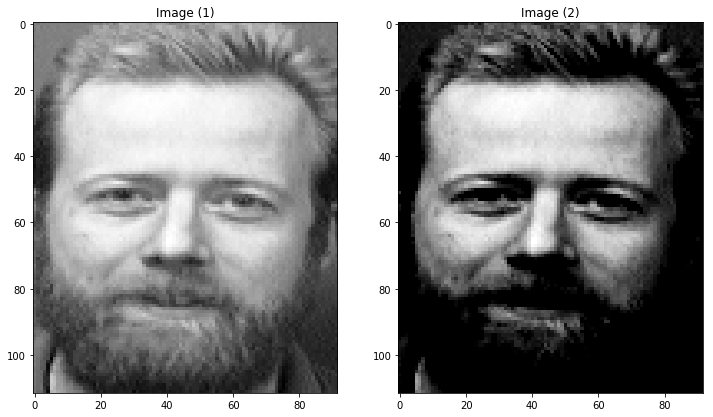

In [218]:
img = np.copy(fr.data[26][0])
show_images([img, darken(img, 100)])

In [219]:
c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = darken(img, 30).flatten().astype('float64')
        c_, dc = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        # print('class: ', np.argmax(c_)//5 + 1, ', ', i == np.argmax(c_)//5 + 1)
        c_list.append(c_)
        
print('score: ', np.mean(np.array([np.argmax(c_)//5 + 1 for c_ in c_list])==np.array(fr.true_class)))

score:  0.78


## Benchmark with KNN

In [204]:
def knn_classifier(fr, n_neighbors=3):
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(np.transpose(fr.phi), fr.true_class)
    return neigh

In [221]:
knn = knn_classifier(fr, 1)
class_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        cls = knn.predict([img.flatten().astype('float64')])[0]
#        print('class: ', c_)
        class_list.append(cls)
        
print('score: ', np.mean(np.array(class_list)==np.array(fr.true_class)))

score:  0.905


In [222]:
knn = knn_classifier(fr, 1)
class_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        cls = knn.predict([darken(img, 30).flatten().astype('float64')])[0]
#        print('class: ', c_)
        class_list.append(cls)
        
print('score: ', np.mean(np.array(class_list)==np.array(fr.true_class)))

score:  0.53


# Fast L1 minimisation with occlusion

On cherche à minimiser la fonction de Lagrange augmentée:
$$
L_\mu(c, e, \nu) = \|c\|_1 + \|e\|_1 + ⟨\nu,y-\Phi c-e⟩ + \frac{\mu}{2}\|y-\Phi c-e\|_2^2
$$

Pour cela on va approcher les grandeurs cibles par un algorithme iteratif. $$(c^*,e^*,\nu^*)$$

A chaque étape, on calcule:
$$
e_{k+1} = argmin_e L_{\mu_k}(c_k, ., \nu_k)
$$

$$
c_{k+1} = argmin_c L_{\mu_k}(., e_{k+1}, \nu_k)
$$

$$
\nu_{k+1} = \nu_k + \mu_k(y-\Phi c_{k+1} - e_{k+1})
$$

L'optimisation de c se fait à l'aide d'un algorithme FISTA.# Fast l1 minimisation with occlusion

In [235]:
# ALGORITHM

def minimization_with_occlusion(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=1000):
    m, n = fr.phi.shape
    iter_ = 0

    c = np.zeros(n)
    e = np.copy(y)
    v = np.zeros(m)
    de = np.ones(n)
    dc = np.ones(n)
    dc_list = []
    while np.linalg.norm(dc) > epsilon and iter_ < iter_max:
        iter_ += 1
        #if iter_%100 == 0:
            #show_images([(np.dot(fr.phi, c)).astype('uint8').reshape((25, 25)), (e).astype('uint8').reshape((25, 25))])
        #print('de: ', np.linalg.norm(de))
        #print('dc: ', np.linalg.norm(dc))
        #print('dpc: ', np.linalg.norm(np.dot(fr.phi, dc)))
        #print('------------------------')

        de = shrink(y - np.dot(fr.phi, c) + v / mu, 1 / mu) - e
        e += de
        t = 1
        z = np.ones(n)
        w = np.copy(c)
        dw = np.ones(n)
        
        #FISTA
        while np.linalg.norm(dw) > epsilon_fista:
            # print('dw: ', np.linalg.norm(dw))
            left = z + np.dot(np.transpose(fr.phi), y - np.dot(fr.phi, z) - e + v / mu) / gamma
            dw = shrink(left, 1 / (mu * gamma)) - w
            w += dw
            dt = (1 + np.sqrt(1 + 4 * t ** 2)) / 2 - t
            t += dt
            z = w + (t - dt - 1) / t * dw

        dc = w - c
        c += dc
        dc_list.append(np.linalg.norm(dc))
        v = v + mu *(y - np.dot(fr.phi, c) - e)
        mu += mu_iter
        
    return c, dc_list, e

In [236]:
# PARAMETERS

epsilon = 0.1
epsilon_fista = 0.001

# gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi)))
gamma = 10000000000

mu = 2*reduction_size[0]*reduction_size[1]/np.linalg.norm(y, ord=1)
mu_iter = 1

iter_max = 20

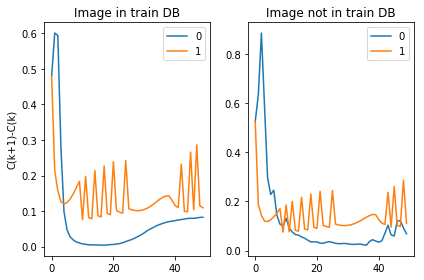

In [237]:
# load images
fr = Recognition(resize=reduction_size)

iter_max = 50
mu_iter_list = [0, 1]

# image in train DB
y1 = fr.resized_data[11][0].flatten().astype('float64')
# image not in train DB
y2 = fr.resized_data[11][6].flatten().astype('float64')

deltac = [[], []]
for dc, y in zip(deltac, [y1, y2]):
    for mu_i in mu_iter_list:
        # print(mu_i)
        c, dc_list, e = minimization_with_occlusion(fr, y, 0., epsilon_fista, gamma, mu, mu_i, iter_max=iter_max)
        dc.append(dc_list)
        
t = np.arange(iter_max)

plt.subplot(1, 2, 1)
plt.plot(t, deltac[0][0], t, deltac[0][1])
plt.legend(list(map(str, mu_iter_list)))
plt.title('Image in train DB')
plt.ylabel('C(k+1)-C(k)')

plt.subplot(1, 2, 2)
plt.plot(t, deltac[1][0], t, deltac[1][1])
plt.legend(list(map(str, mu_iter_list)))
plt.title('Image not in train DB')

plt.tight_layout()
plt.show()

In [234]:
c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = img.flatten().astype('float64')
        c_, e = minimization_with_occlusion(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        print('class: ', np.argmax(c_)//5 + 1, ', ', i == np.argmax(c_)//5 + 1)
        c_list.append(c_)
        
print('score: ', np.mean(np.array([np.argmax(c_)//5 + 1 for c_ in c_list])==np.array(fr.true_class)))

class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False
class:  22 ,  False


KeyboardInterrupt: 

mu:  0.015583508907533692


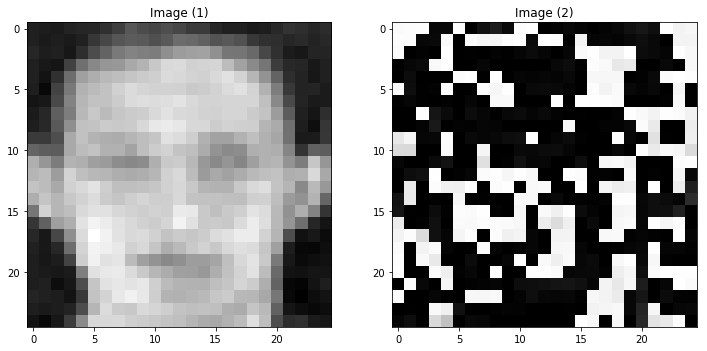

KeyboardInterrupt: 

In [442]:
a, b = (1, 0)

img_ = np.copy(fr.resized_data[a][b])
# img_[10:15, 10:15] = 0

c, e = fr.minimization_with_occlusion(img_.flatten().astype('float64'), epsilon=0.001, niter=1000)
img = (np.dot(fr.phi, c)).astype('uint8').reshape((25, 25))
error = (e).astype('uint8').reshape((25, 25))

show_images([fr.data[a][b], img_, img, error], cols=1, titles=['original', 'reduced', 'recreated', 'error'])

print(np.argmax(c)//5+1)
plt.bar(np.arange(c.shape[0]), c)
plt.show()

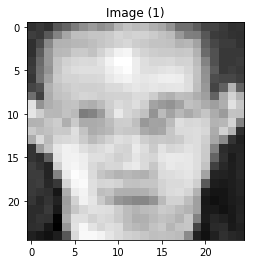

In [192]:
img = (np.dot(fr.phi, c)+e).astype('uint8').reshape((25, 25))
show_images([img])

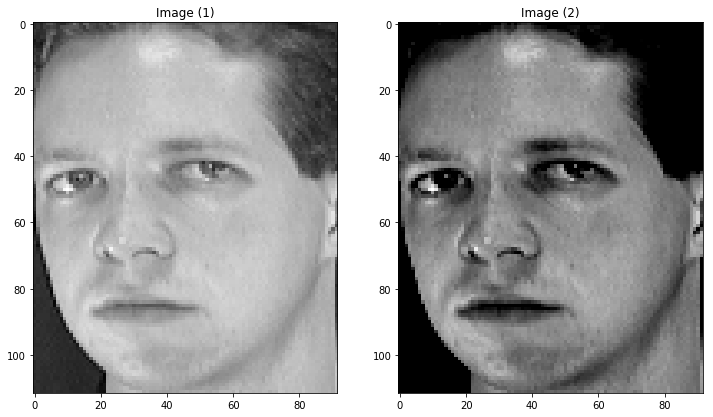

In [292]:
img = np.copy(fr.data[a][b])
def darken_(x, u):
    return max(0, x-u)

darken = np.vectorize(darken_)

show_images([img, darken(img, 100)])

# KNN

In [309]:
knn = fr.knn(1)

In [310]:
c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        c_ = knn.predict([darken(img, 30).flatten().astype('float64')])[0]
#        print('class: ', c_)
        c_list.append(c_)
        
l = [[i]*5 for i in range(1, 41)]
true_class =[j for l_ in l for j in l_]
print('score: ', np.mean(np.array(c_list)==np.array(true_class)))

score:  0.53


# occlusion

In [ ]:
def minimization_with_occlusion(self, y, epsilon=0.15, niter=20):
    m, n = self.phi.shape
    iter_ = 0
    # phi = np.random.randint(2, 200, (m, n))
    self.gamma = 10000000000

    shrink = np.vectorize(self.shrink)
    c = np.zeros(n)
    e = np.copy(y)
    v = np.zeros(m)
    mu = 2*25**2/np.linalg.norm(y, ord=1)
    print('mu: ', mu)
    de = np.ones(n)
    dc = np.ones(n)
    while np.linalg.norm(dc) > epsilon and iter_ < niter:
        iter_ += 1
        if iter_%100 == 0:
            show_images([(np.dot(self.phi, c)).astype('uint8').reshape((25, 25)), (e).astype('uint8').reshape((25, 25))])
        #print('de: ', np.linalg.norm(de))
        #print('dc: ', np.linalg.norm(dc))
        #print('dpc: ', np.linalg.norm(np.dot(self.phi, dc)))
        #print('------------------------')

        de = shrink(y - np.dot(self.phi, c) + v / mu, 1 / mu) - e
        e += de
        t = 1
        z = np.ones(n)
        w = np.copy(c)
        dw = np.ones(n)
        while np.linalg.norm(dw) > 0.005:
            # print('dw: ', np.linalg.norm(dw))
            left = z + np.dot(np.transpose(self.phi), y - np.dot(self.phi, z) - e + v / mu) / self.gamma
            dw = shrink(left, 1 / (mu * self.gamma)) - w
            w += dw
            dt = (1 + np.sqrt(1 + 4 * t ** 2)) / 2 - t
            t += dt
            z = w + (t - dt - 1) / t * dw

        dc = w - c
        c += dc
        v = v + mu *(y - np.dot(self.phi, c) - e)
        # mu += 0.1
    return c, e

de:  14.142135623730951
de:  3557.081528444351
de:  1119.6344489037176
de:  86.21441699795673
de:  12.275193700171576
de:  3.5133311049883007
de:  1.1691800077629533
de:  0.25286642743479204
de:  0.4753947258957879
de:  0.2139752262748606
de:  0.10319294014440805


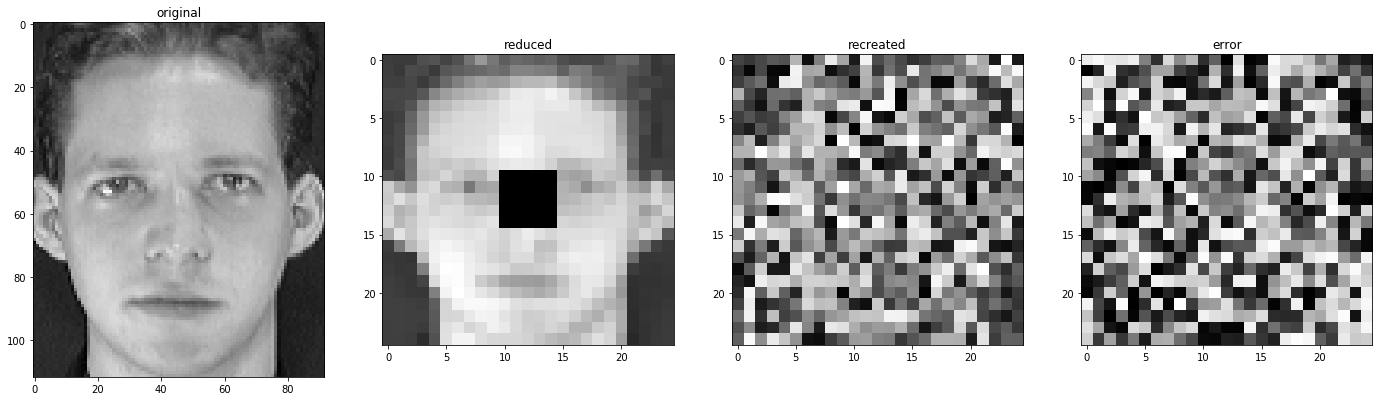

1


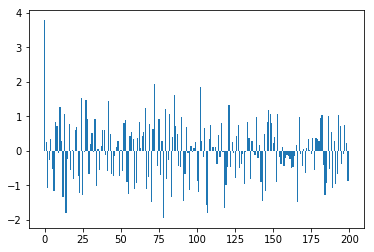

In [460]:
a, b = (1, 0)

img_ = np.copy(fr.resized_data[a][b])
img_[10:15, 10:15] = 0

c = fr.minimization(img_.flatten().astype('float64'), epsilon=0.01)
e = fr.minimization_post_c(img_.flatten().astype('float64'), c, epsilon=0.1)

img = (np.dot(fr.phi, c)).astype('uint8').reshape((25, 25))
error = (e).astype('uint8').reshape((25, 25))

show_images([fr.data[a][b], img_, img, error], cols=1, titles=['original', 'reduced', 'recreated', 'error'])

print(np.argmax(c)//5+1)
plt.bar(np.arange(c.shape[0]), c)
plt.show()